In [1]:
# Install necessary packages
!pip install -q ultralytics ensemble-boxes

# Import standard libraries
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image

# Import PyTorch and YOLO
import torch
from ultralytics import YOLO

# Import ensembling tools
from ensemble_boxes import weighted_boxes_fusion

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

print("✅ Dependencies loaded and random seeds set.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralyti

In [2]:
# Define base paths
base1 = Path('/kaggle/input/falcon-multiclass-cheerios-soup/falcon-multiclass-cheerios-soup')
base2 = Path('/kaggle/input/falcon-multiclass-cheerios-soupv2/falcon-multiclass-cheerios-soupV2')

# Print data information
print("Original Falcon Dataset:")
for split in ['train', 'val']:
    imgs = list((base1 / split / 'images').glob('*.*'))
    labs = list((base1 / split / 'labels').glob('*.txt'))
    print(f"  {split}: {len(imgs)} images, {len(labs)} labels")

for i in range(1, 7):
    d = base2 / f"Scenario{i}"
    t_imgs = len(list((d / 'train' / 'images').glob('*.*')))
    v_imgs = len(list((d / 'val' / 'images').glob('*.*')))
    print(f"Scenario {i}: train={t_imgs}, val={v_imgs}")

Original Falcon Dataset:
  train: 94 images, 94 labels
  val: 6 images, 6 labels
Scenario 1: train=90, val=10
Scenario 2: train=63, val=12
Scenario 3: train=70, val=5
Scenario 4: train=86, val=14
Scenario 5: train=69, val=6
Scenario 6: train=67, val=8


In [3]:
import yaml
from pathlib import Path

# Define mount points
falcon_mount = Path('/kaggle/input/falcon-multiclass-cheerios-soup/falcon-multiclass-cheerios-soup')
v2_mount = Path('/kaggle/input/falcon-multiclass-cheerios-soupv2/falcon-multiclass-cheerios-soupV2')
chal_mount = Path('/kaggle/input/multi-class-object-detection-challenge/Starter_Dataset')

# Auto-discover original Falcon root
train_img_dirs = list(falcon_mount.glob('**/train/images'))
if not train_img_dirs:
    raise FileNotFoundError(f"No nested train/images under {falcon_mount}")
falcon_root = train_img_dirs[0].parents[1]

# Auto-discover V2 root
v2_img_dirs = list(v2_mount.glob('**/Scenario1/train/images'))
if not v2_img_dirs:
    raise FileNotFoundError(f"No Scenario1/train/images under {v2_mount}")
v2_root = v2_img_dirs[0].parents[2]

# Build train list
train_dirs = [
    str(falcon_root / 'train' / 'images'),
    str(falcon_root / 'val' / 'images')
]
for i in range(1, 7):
    train_dirs += [
        str(v2_root / f"Scenario{i}" / 'train' / 'images'),
        str(v2_root / f"Scenario{i}" / 'val' / 'images')
    ]

# Use competition val folder for validation
val_dirs = [
    str(chal_mount / 'val' / 'images')
]

# Test set
test_dir = str(chal_mount / 'testImages' / 'images')

# Assemble and write YAML
data = {
    'train': train_dirs,
    'val': val_dirs,
    'test': test_dir,
    'nc': 2,
    'names': ['cheerios', 'soup']
}

with open('data.yaml', 'w') as f:
    yaml.safe_dump(data, f, sort_keys=False, default_flow_style=False)

print("✅ data.yaml created:")
print(open('data.yaml').read())

✅ data.yaml created:
train:
- /kaggle/input/falcon-multiclass-cheerios-soup/falcon-multiclass-cheerios-soup/train/images
- /kaggle/input/falcon-multiclass-cheerios-soup/falcon-multiclass-cheerios-soup/val/images
- /kaggle/input/falcon-multiclass-cheerios-soupv2/falcon-multiclass-cheerios-soupV2/Scenario1/train/images
- /kaggle/input/falcon-multiclass-cheerios-soupv2/falcon-multiclass-cheerios-soupV2/Scenario1/val/images
- /kaggle/input/falcon-multiclass-cheerios-soupv2/falcon-multiclass-cheerios-soupV2/Scenario2/train/images
- /kaggle/input/falcon-multiclass-cheerios-soupv2/falcon-multiclass-cheerios-soupV2/Scenario2/val/images
- /kaggle/input/falcon-multiclass-cheerios-soupv2/falcon-multiclass-cheerios-soupV2/Scenario3/train/images
- /kaggle/input/falcon-multiclass-cheerios-soupv2/falcon-multiclass-cheerios-soupV2/Scenario3/val/images
- /kaggle/input/falcon-multiclass-cheerios-soupv2/falcon-multiclass-cheerios-soupV2/Scenario4/train/images
- /kaggle/input/falcon-multiclass-cheerios-so

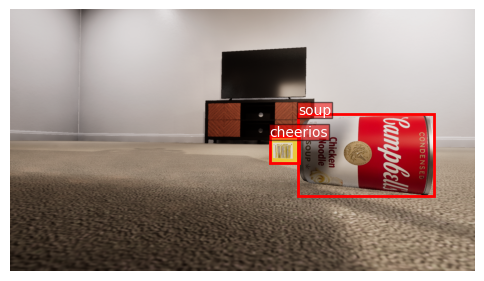

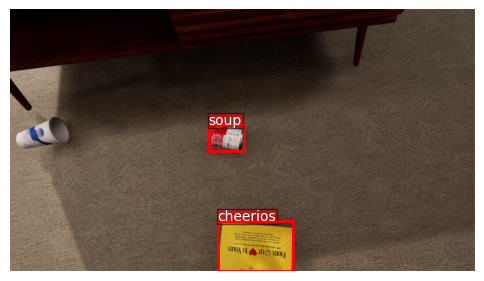

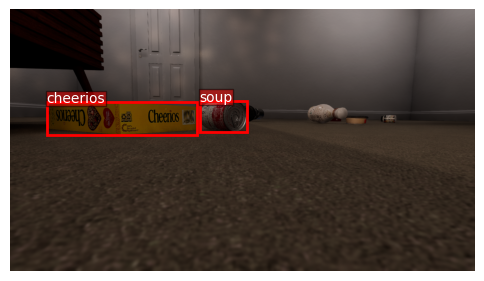

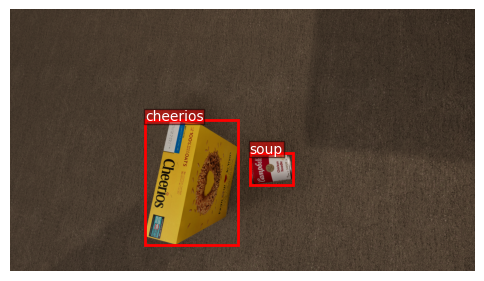

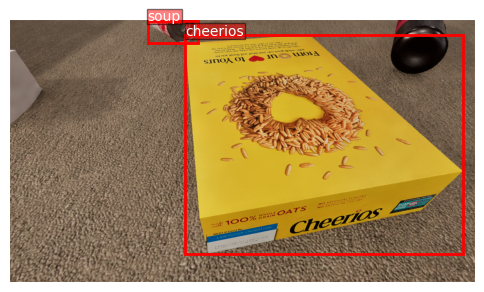

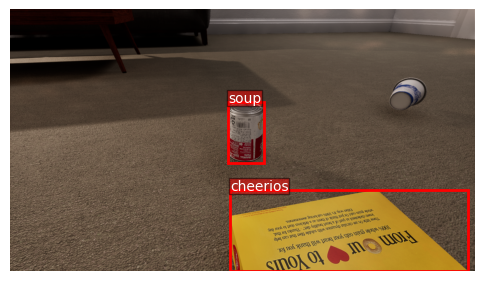

In [4]:
from pathlib import Path
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Define roots
orig_root = Path('/kaggle/input/falcon-multiclass-cheerios-soup/falcon-multiclass-cheerios-soup')
v2_root = Path('/kaggle/input/falcon-multiclass-cheerios-soupv2/falcon-multiclass-cheerios-soupV2')

# Build list of (images, labels) for original + each Scenario
train_pairs = [
    (orig_root / 'train' / 'images', orig_root / 'train' / 'labels'),
]
for i in range(1, 7):
    scen = v2_root / f'Scenario{i}'
    train_pairs += [
        (scen / 'train' / 'images', scen / 'train' / 'labels'),
        (scen / 'val' / 'images', scen / 'val' / 'labels'),
    ]

# Gather all (img_path, lbl_path) tuples
all_samples = []
for img_dir, lbl_dir in train_pairs:
    if img_dir.exists() and lbl_dir.exists():
        for img_path in img_dir.glob('*.*'):
            lbl_path = lbl_dir / f"{img_path.stem}.txt"
            all_samples.append((img_path, lbl_path))

# Sample a few examples
num_to_show = 6
sampled = random.sample(all_samples, k=min(len(all_samples), num_to_show))

classes = ['cheerios', 'soup']

# Plot
for img_path, lbl_path in sampled:
    img = Image.open(img_path)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img)
    if lbl_path.exists():
        with open(lbl_path) as f:
            for line in f:
                cls_id, x_c, y_c, w, h = map(float, line.split())
                img_w, img_h = img.size
                x1 = (x_c - w / 2) * img_w
                y1 = (y_c - h / 2) * img_h
                rect = patches.Rectangle((x1, y1), w * img_w, h * img_h,
                                         linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
                ax.text(x1, y1, classes[int(cls_id)],
                        color='white', fontsize=10,
                        bbox=dict(facecolor='red', alpha=0.5, pad=0.5))
    ax.axis('off')
    plt.show()

In [5]:
from ultralytics import YOLO

# Toggle training on/off
TRAIN = True

if TRAIN:
    model = YOLO("yolov8x.pt")  # or your custom checkpoint

    model.train(
        data="data.yaml",
        epochs=75,
        batch=16,
        imgsz=512,
        optimizer="SGD",
        lr0=0.002,
        lrf=0.0001,
        weight_decay=0.0001,
        dropout=0.3,
        dfl=0.75,
        cos_lr=True,
        patience=100,
        save_period=10,
        project="runs/train",
        exist_ok=True,
        plots=True,
        augment=True,
        mosaic=1.0,
        mixup=0.25,
        cutmix=0.25,
        copy_paste=0.05,
        close_mosaic=10,
        hsv_h=0.05, hsv_s=1.0, hsv_v=0.75,
        flipud=0.1, fliplr=0.6,
        translate=0.1, scale=0.6, shear=0.02,
        warmup_epochs=5, warmup_momentum=1,
        workers=4,
        conf=0.25, iou=0.5
    )

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=0.25, copy_paste=0.05, copy_paste_mode=flip, cos_lr=True, cutmix=0.25, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=0.75, dnn=False, dropout=0.3, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=True, fliplr=0.6, flipud=0.1, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.05, hsv_s=1.0, hsv_v=0.75, imgsz=512, int8=False, iou=0.5, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.0001, mask_ratio=4, max_det=300, mixup=0.25, mode=train, model=yolov8x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=F

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.2±0.2 ms, read: 88.6±33.1 MB/s, size: 2641.1 KB)


train: Scanning /kaggle/input/falcon-multiclass-cheerios-soup/falcon-multiclass-cheerios-soup/train/labels... 600 images, 7 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:08<00:00, 68.50it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/falcon-multiclass-cheerios-soup/falcon-multiclass-cheerios-soup/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 139.7±20.7 MB/s, size: 24192.4 KB)


val: Scanning /kaggle/input/multi-class-object-detection-challenge/Starter_Dataset/val/labels... 95 images, 2 backgrounds, 0 corrupt: 100%|██████████| 95/95 [00:04<00:00, 22.78it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/multi-class-object-detection-challenge/Starter_Dataset/val is not writeable, cache not saved.


Plotting labels to runs/train/train/labels.jpg... 
optimizer: SGD(lr=0.002, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0001), 103 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/train/train
Starting training for 75 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/75      7.83G      0.528      2.381     0.4958         31        512: 100%|██████████| 38/38 [00:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

                   all         95        172      0.609      0.697      0.651      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/75      8.04G      0.443     0.7953     0.4849         37        512: 100%|██████████| 38/38 [00:40<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all         95        172      0.904      0.795      0.902      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/75      7.85G     0.4144     0.4783     0.4721         28        512: 100%|██████████| 38/38 [00:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all         95        172      0.833      0.832      0.899      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/75      7.84G     0.3874     0.4088     0.4555         31        512: 100%|██████████| 38/38 [00:41<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         95        172      0.878      0.837      0.905      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/75      7.99G     0.4011      0.401      0.456         36        512: 100%|██████████| 38/38 [00:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         95        172      0.859      0.872        0.9      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/75      7.99G     0.3941      0.369     0.4596         34        512: 100%|██████████| 38/38 [00:40<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         95        172      0.831      0.849      0.888      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/75      7.98G     0.3679     0.3394     0.4485         33        512: 100%|██████████| 38/38 [00:42<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         95        172      0.868      0.828      0.895      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/75      7.99G     0.3747     0.3427     0.4454         24        512: 100%|██████████| 38/38 [00:40<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         95        172      0.875      0.877      0.918      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/75       8.1G     0.3716      0.328     0.4493         26        512: 100%|██████████| 38/38 [00:41<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         95        172      0.908       0.83      0.901       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/75         8G     0.3778     0.3309     0.4476         33        512: 100%|██████████| 38/38 [00:40<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         95        172      0.856      0.804      0.894      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/75      7.99G     0.3677     0.3152     0.4482         29        512: 100%|██████████| 38/38 [00:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         95        172      0.894      0.804       0.89      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/75      8.07G     0.3836     0.3195     0.4525         45        512: 100%|██████████| 38/38 [00:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         95        172      0.856      0.871      0.903      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/75      8.01G     0.3647     0.3093     0.4485         47        512: 100%|██████████| 38/38 [00:40<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         95        172      0.883      0.808      0.897      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/75      8.08G     0.3715     0.3083     0.4498         27        512: 100%|██████████| 38/38 [00:41<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         95        172      0.866      0.851      0.913      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/75      8.02G     0.3571     0.3008     0.4411         43        512: 100%|██████████| 38/38 [00:41<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         95        172      0.904      0.833      0.908      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/75         8G     0.3663     0.3097     0.4384         40        512: 100%|██████████| 38/38 [00:41<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         95        172      0.871      0.811      0.892      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/75      8.01G     0.3454     0.2868     0.4407         35        512: 100%|██████████| 38/38 [00:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         95        172       0.91      0.775      0.889      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/75      8.08G     0.3472     0.2856     0.4441         26        512: 100%|██████████| 38/38 [00:41<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         95        172      0.911      0.775      0.881      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/75      8.01G     0.3412     0.2856     0.4385         31        512: 100%|██████████| 38/38 [00:41<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         95        172      0.922      0.813      0.891      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/75         8G       0.36     0.2937     0.4419         41        512: 100%|██████████| 38/38 [00:40<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         95        172      0.911      0.846      0.919      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/75      8.02G     0.3495     0.2795     0.4398         34        512: 100%|██████████| 38/38 [00:42<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         95        172      0.886      0.843      0.912      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/75      8.09G     0.3465     0.2753     0.4449         48        512: 100%|██████████| 38/38 [00:41<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         95        172      0.857      0.872      0.917      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/75      8.01G     0.3451     0.2714     0.4371         28        512: 100%|██████████| 38/38 [00:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         95        172      0.899      0.871      0.928      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/75      8.09G     0.3549     0.2826     0.4439         30        512: 100%|██████████| 38/38 [00:40<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         95        172       0.89      0.899       0.92      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/75      8.01G     0.3413     0.2664     0.4377         41        512: 100%|██████████| 38/38 [00:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         95        172      0.894      0.889      0.917      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/75         8G     0.3485     0.2773     0.4407         49        512: 100%|██████████| 38/38 [00:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         95        172       0.89      0.851      0.908      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/75      8.02G     0.3482      0.274     0.4422         29        512: 100%|██████████| 38/38 [00:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         95        172      0.869      0.878      0.916      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/75         8G     0.3265     0.2537     0.4364         40        512: 100%|██████████| 38/38 [00:42<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         95        172        0.9      0.826      0.911      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/75      8.01G     0.3287     0.2575     0.4385         48        512: 100%|██████████| 38/38 [00:40<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         95        172      0.858      0.873      0.916      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/75      8.08G     0.3373     0.2531     0.4414         53        512: 100%|██████████| 38/38 [00:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         95        172      0.883      0.872      0.915       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/75         8G     0.3191     0.2496     0.4354         27        512: 100%|██████████| 38/38 [00:40<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         95        172      0.866      0.872      0.915      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/75      8.08G     0.3186     0.2497     0.4369         38        512: 100%|██████████| 38/38 [00:40<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         95        172      0.905      0.878      0.941      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/75         8G     0.3234     0.2547     0.4377         43        512: 100%|██████████| 38/38 [00:40<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         95        172      0.907      0.858      0.926      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/75      8.07G     0.3266     0.2535     0.4378         36        512: 100%|██████████| 38/38 [00:41<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         95        172      0.903       0.85      0.931      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/75      7.99G     0.3244     0.2465     0.4352         28        512: 100%|██████████| 38/38 [00:41<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         95        172      0.927      0.883      0.948      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/75      8.08G     0.3189      0.253     0.4364         40        512: 100%|██████████| 38/38 [00:39<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         95        172      0.907        0.9      0.946      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/75      8.12G     0.3138     0.2413     0.4348         26        512: 100%|██████████| 38/38 [00:41<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         95        172      0.948      0.877      0.939      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/75      8.09G     0.3122     0.2329     0.4315         39        512: 100%|██████████| 38/38 [00:41<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         95        172      0.892       0.87      0.925      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/75      8.09G     0.3061      0.239     0.4359         29        512: 100%|██████████| 38/38 [00:41<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         95        172      0.909      0.869      0.933      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/75      8.08G     0.3059     0.2293      0.432         22        512: 100%|██████████| 38/38 [00:41<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         95        172      0.889      0.861      0.931      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/75      8.09G      0.313     0.2299     0.4303         33        512: 100%|██████████| 38/38 [00:40<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all         95        172      0.919      0.855      0.918      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/75         8G     0.3077     0.2324     0.4325         49        512: 100%|██████████| 38/38 [00:41<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         95        172      0.917      0.842      0.919      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/75      8.02G     0.3084      0.238     0.4333         34        512: 100%|██████████| 38/38 [00:41<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         95        172      0.907       0.88      0.935      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/75      8.01G     0.3007     0.2294     0.4302         29        512: 100%|██████████| 38/38 [00:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         95        172        0.9      0.884       0.93      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/75      8.01G        0.3     0.2298     0.4347         38        512: 100%|██████████| 38/38 [00:40<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         95        172      0.908      0.859      0.923      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/75         8G     0.2908      0.221     0.4324         37        512: 100%|██████████| 38/38 [00:41<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         95        172        0.9       0.89       0.92      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/75      8.08G     0.3044      0.237      0.436         34        512: 100%|██████████| 38/38 [00:41<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

                   all         95        172      0.891      0.885      0.917      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/75      8.08G     0.3019     0.2283     0.4326         28        512: 100%|██████████| 38/38 [00:41<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         95        172      0.931      0.872      0.921       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/75      8.08G     0.2949     0.2217     0.4326         31        512: 100%|██████████| 38/38 [00:40<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         95        172      0.938      0.872      0.922      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/75      8.07G     0.2958     0.2224     0.4369         32        512: 100%|██████████| 38/38 [00:40<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         95        172      0.926      0.875      0.928      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/75         8G     0.2863     0.2172      0.432         33        512: 100%|██████████| 38/38 [00:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         95        172      0.926      0.889      0.928       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/75      8.08G     0.2789     0.2087     0.4306         40        512: 100%|██████████| 38/38 [00:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         95        172      0.953      0.865      0.934      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/75      8.01G     0.2869     0.2134     0.4323         35        512: 100%|██████████| 38/38 [00:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         95        172      0.936      0.861       0.93      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/75      8.08G     0.2877     0.2113     0.4287         32        512: 100%|██████████| 38/38 [00:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         95        172      0.928      0.896      0.934      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/75      8.09G     0.2805     0.2184     0.4317         41        512: 100%|██████████| 38/38 [00:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         95        172      0.915      0.886      0.934      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/75         8G     0.2874     0.2202     0.4329         29        512: 100%|██████████| 38/38 [00:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         95        172      0.922      0.896      0.933      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/75      8.01G     0.2816     0.2092     0.4274         27        512: 100%|██████████| 38/38 [00:41<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         95        172      0.912      0.897      0.934      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/75      8.09G     0.2749     0.2044     0.4259         39        512: 100%|██████████| 38/38 [00:40<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         95        172      0.905      0.896      0.934      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/75      8.09G      0.281     0.2027     0.4309         35        512: 100%|██████████| 38/38 [00:42<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all         95        172      0.903        0.9      0.933      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/75         8G     0.2792     0.1994     0.4299         41        512: 100%|██████████| 38/38 [00:40<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         95        172      0.938      0.872      0.932      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/75      8.02G     0.2802     0.2009     0.4321         32        512: 100%|██████████| 38/38 [00:42<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         95        172      0.937      0.864      0.933      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/75      8.08G     0.2835     0.2072     0.4331         45        512: 100%|██████████| 38/38 [00:41<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         95        172      0.945      0.866      0.934      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/75      8.01G     0.2718     0.1958      0.429         43        512: 100%|██████████| 38/38 [00:40<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all         95        172      0.938      0.864      0.932      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/75      8.08G     0.2633     0.1965     0.4269         35        512: 100%|██████████| 38/38 [00:41<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         95        172      0.942      0.861      0.931      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/75      8.08G     0.2751     0.1984     0.4307         30        512: 100%|██████████| 38/38 [00:42<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         95        172      0.945      0.864      0.932      0.875


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/75      8.06G     0.1797     0.1362      0.394         15        512: 100%|██████████| 38/38 [00:40<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         95        172      0.938      0.878      0.925      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/75      8.07G     0.1706     0.1271      0.393         14        512: 100%|██████████| 38/38 [00:35<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]

                   all         95        172      0.906      0.895      0.921      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/75      8.06G     0.1632     0.1274     0.3927         14        512: 100%|██████████| 38/38 [00:35<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]

                   all         95        172      0.906      0.889      0.921       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/75      7.98G     0.1647     0.1207     0.3924         14        512: 100%|██████████| 38/38 [00:35<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         95        172      0.907      0.878       0.92      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/75      8.06G     0.1594     0.1171     0.3901         14        512: 100%|██████████| 38/38 [00:35<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         95        172      0.918      0.877      0.921       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/75      7.99G     0.1695     0.1239     0.3943         13        512: 100%|██████████| 38/38 [00:34<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         95        172      0.929      0.873      0.924      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/75      8.06G     0.1702     0.1223     0.3917         13        512: 100%|██████████| 38/38 [00:35<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         95        172      0.882      0.907      0.925      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/75         8G     0.1717     0.1243     0.3912         14        512: 100%|██████████| 38/38 [00:35<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all         95        172      0.929      0.852      0.923      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/75      7.99G     0.1672       0.12      0.388         13        512: 100%|██████████| 38/38 [00:36<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         95        172       0.89      0.901       0.92      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/75         8G     0.1719     0.1244     0.3917         14        512: 100%|██████████| 38/38 [00:36<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all         95        172      0.923      0.857      0.922      0.869



75 epochs completed in 0.930 hours.
Optimizer stripped from runs/train/train/weights/last.pt, 136.7MB
Optimizer stripped from runs/train/train/weights/best.pt, 136.7MB

Validating runs/train/train/weights/best.pt...
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,125,494 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.17s/it]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         95        172      0.926      0.877       0.94      0.883
              cheerios         88         88      0.913      0.852      0.941      0.898
                  soup         84         84      0.938      0.901      0.938      0.867
Speed: 0.1ms preprocess, 40.4ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/train/train


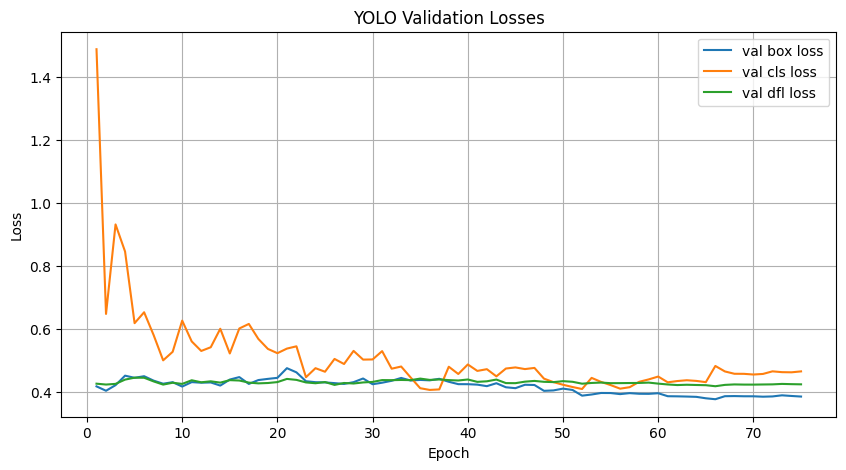

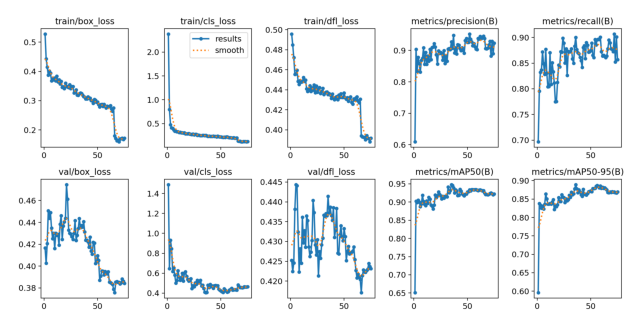

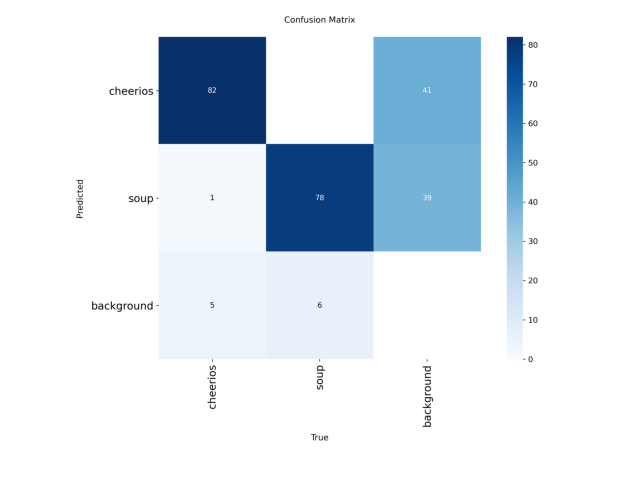

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# Point to your training run directory
exp_dir = Path("/kaggle/working/runs/train/train")  # adjust if different
results_csv = exp_dir / "results.csv"

# Load the per-epoch metrics
results = pd.read_csv(results_csv)

# Plot validation losses over epochs
plt.figure(figsize=(10, 5))
plt.plot(results['epoch'], results['val/box_loss'], label='val box loss')
plt.plot(results['epoch'], results['val/cls_loss'], label='val cls loss')
plt.plot(results['epoch'], results['val/dfl_loss'], label='val dfl loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('YOLO Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

# Display the confusion matrix image(s)
cm_paths = [
    exp_dir / "results.png",
    exp_dir / "confusion_matrix.png"
]
for p in cm_paths:
    if p.exists():
        img = Image.open(p)
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
        print(f"No file at {p}")

In [7]:
import csv
import pandas as pd
from pathlib import Path
from PIL import Image
from ultralytics import YOLO
from ensemble_boxes import weighted_boxes_fusion

def filter_invalid_boxes(boxes, scores, labels):
    filtered_boxes, filtered_scores, filtered_labels = [], [], []
    for b, s, l in zip(boxes, scores, labels):
        if abs(b[2] - b[0]) > 1e-6 and abs(b[3] - b[1]) > 1e-6:
            filtered_boxes.append(b)
            filtered_scores.append(s)
            filtered_labels.append(l)
    return filtered_boxes, filtered_scores, filtered_labels

def run_inference(models, image_sizes, test_images_path, conf=0.25, iou_thr=0.5):
    test_dir = Path(test_images_path)
    image_paths = [p for p in test_dir.glob('*') if p.suffix.lower() in ('.jpg', '.jpeg', '.png')]
    predictions = {}

    for mi, model in enumerate(models):
        model.eval()
        predictions[mi] = {}
        for size in image_sizes:
            predictions[mi][size] = {}
            for img_path in image_paths:
                image_id = img_path.stem
                img = Image.open(img_path)
                w, h = img.size

                # Run predict
                results = model.predict(source=str(img_path),
                                        conf=conf, iou=iou_thr,
                                        imgsz=size, augment=True,
                                        verbose=False)
                # Collect all boxes for this image/size
                boxes, scores, labels = [], [], []
                for r in results:
                    if r.boxes is None:
                        continue
                    boxes = r.boxes.xyxy.cpu().numpy().tolist()
                    scores = r.boxes.conf.cpu().numpy().tolist()
                    labels = r.boxes.cls.cpu().numpy().tolist()

                # Normalize & filter
                norm_boxes = [[x1 / w, y1 / h, x2 / w, y2 / h] for x1, y1, x2, y2 in boxes]
                norm_boxes, scores, labels = filter_invalid_boxes(norm_boxes, scores, labels)

                predictions[mi][size][image_id] = {"boxes": norm_boxes,
                                                  "scores": scores,
                                                  "labels": labels}
    return predictions

# Specify your checkpoints and test folder
model_paths = [
    '/kaggle/input/3lc-yolo-baseline-submission/Duality-3LC-Kaggle/run-1/weights/best.pt',
    '/kaggle/working/runs/train/train/weights/best.pt']

test_images_path = '/kaggle/input/multi-class-object-detection-challenge/testImages/images'

# Load models
models = [YOLO(p) for p in model_paths]

# Run batched, multi-scale inference
image_sizes = [640, 800, 864]
predictions = run_inference(models, image_sizes, test_images_path,
                            conf=0.05, iou_thr=0.35)

# Collect all image_ids
first_model = predictions[next(iter(predictions))]
first_scale = first_model[next(iter(first_model))]
image_ids = list(first_scale.keys())

# Fuse & build submission rows
rows = []
for img_id in image_ids:
    all_boxes, all_scores, all_labels = [], [], []
    for model_preds in predictions.values():
        for size_preds in model_preds.values():
            if img_id in size_preds:
                p = size_preds[img_id]
                if p['boxes']:
                    all_boxes.append(p['boxes'])
                    all_scores.append(p['scores'])
                    all_labels.append(p['labels'])
    if all_boxes:
        fb, fs, fl = weighted_boxes_fusion(all_boxes, all_scores, all_labels,
                                           iou_thr=0.35, skip_box_thr=0.01)
        pred_str = " ".join(
            f"{int(l)} {s:.6f} {(b[0] + b[2]) / 2:.6f} {(b[1] + b[3]) / 2:.6f} {(b[2] - b[0]):.6f} {(b[3] - b[1]):.6f}"
            for b, s, l in zip(fb, fs, fl)
        )
    else:
        pred_str = "no boxes"
    rows.append({'image_id': img_id, 'prediction_string': pred_str})

# Save to CSV
submission_df = pd.DataFrame(rows)
submission_df.to_csv('submission.csv', index=False, quoting=csv.QUOTE_MINIMAL)
print(f"✅ submission.csv created with {len(submission_df)} entries.")

✅ submission.csv created with 229 entries.
